## ДЗ №1. Метрики и простейшие алгоритмы рекомендаций

## Общая информация
**Дата выдачи: 4 февраля 2025**

**Дедлайн: 12 февраля 2025 23:59 MSK**

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from typing import List, Optional
from metric_tests import run_tests

%matplotlib inline

## О задании

В этой работе мы посмотрим на то, как работают самые простые модели для рекомендаций. Как правило, они не требуют построения специальных моделей, но даже так оказываются полезны в качестве бейзлайна. Попробуем сделать предсказания с помощью EASE. Это тоже довольно простой подход, но не стоит забывать, что сложные модели могут оказаться не лучшим выбором в условиях большого количества данных. Посчитаем метрики, построим графики и подумаем, насколько хорошо эти модели вообще решают поставленную задачу.

Мы будем работать с датасетом по рекомендации фильмов от Kion MTS, который был дан для соревнования. Сперва нужно его предобработать, эта часть повторяет то, что было на семинаре.

Датасет необходимо скачать: https://ods.ai/competitions/competition-recsys-21/data

Оттуда нужны файлы `interactions.csv` и `items.csv`

Каждое задание весит **1 балл**, если выполнено полностью и без ошибок, **0 баллов** ставится при наличии хотя бы 1 ошибки. Максимальная оценка - **10 баллов**. Шаблоны функций и классов можно менять по своему усмотрению.

In [2]:
df = pd.read_csv('interactions.csv').iloc[:-1]
df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
0,176549,9506,2021-05-11,4250,72.0
1,699317,1659,2021-05-29,8317,100.0
2,656683,7107,2021-05-09,10,0.0
3,864613,7638,2021-07-05,14483,100.0
4,964868,9506,2021-04-30,6725,100.0


In [3]:
df['last_watch_dt'] = (pd.to_datetime(df['last_watch_dt']) - pd.to_datetime(df['last_watch_dt']).min())
df['last_watch_dt'] = df.last_watch_dt.apply(lambda x: int(str(x).split()[0]))
df.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct
5057842,387503,1027,118,83,1.0
1646727,781241,10569,158,354,10.0
5124921,661351,144,145,4899,65.0
4572745,640989,2657,162,328,0.0
3268201,508306,4880,40,7069,9.0


Сделаем разбиение по времени

<Axes: >

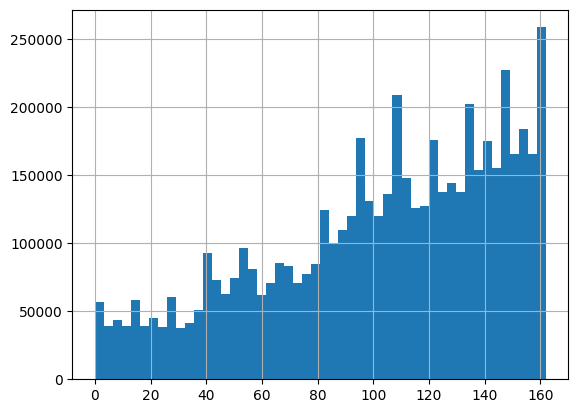

In [4]:
df.last_watch_dt.hist(bins=50)

In [5]:
train_df = df.loc[(df.last_watch_dt < 160-7)].copy()
test_df = df.loc[(df.last_watch_dt >= 160-7)].copy()

train_users = train_df.user_id.unique()
test_users = test_df.user_id.unique()

all_included = np.intersect1d(train_users, test_users)

print('число людей и там и там: ', all_included.shape[0])
print('число людей всего:', train_users.shape[0])

число людей и там и там:  134670
число людей всего: 880449


In [6]:
len(set(test_users) - set(train_users)) / len(test_users)

0.37768022181146027

И переведём всё к соединённому датасету:

In [7]:
n_users = 10000

all_included = np.random.choice(all_included, size=n_users, replace=False)

train_df = train_df.loc[train_df.user_id.isin(all_included)].copy()
test_df = test_df.loc[test_df.user_id.isin(all_included)].copy()

assert train_df.last_watch_dt.max() < test_df.last_watch_dt.min()
assert train_df.user_id.nunique() == n_users
assert test_df.user_id.nunique() == n_users

In [8]:
train_df.head()

,user_id,item_id,last_watch_dt,total_dur,watched_pct
20,896751,8081,65,6358,100.0
119,10543,821,64,112,0.0
139,447592,1241,126,127,3.0
151,648287,7612,133,2396,36.0
189,969875,372,122,567,12.0


In [9]:
train_grouped = train_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                 x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
train_grouped.rename({0:'train_interactions'}, axis=1, inplace=True)

test_grouped = test_df.groupby('user_id').apply(
    lambda x: [(t1, t2) for t1, t2 in sorted(zip(x.item_id,
                                                         x.last_watch_dt), key=lambda x: x[1])]
).reset_index()
test_grouped.rename({0:'test_interactions'}, axis=1, inplace=True)

train_grouped.head()

<ipython-input-9-2ac47bd011f3>:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  train_grouped = train_df.groupby('user_id').apply(
<ipython-input-9-2ac47bd011f3>:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  test_grouped = test_df.groupby('user_id').apply(


,user_id,train_interactions
0,537,"[(3734, 125), (7626, 125), (1785, 126), (9728,..."
1,566,"[(2496, 43)]"
2,581,"[(10440, 127)]"
3,622,"[(10436, 10), (1324, 10), (1844, 13), (4382, 1..."
4,628,"[(8643, 135), (7570, 136), (6419, 142), (2483,..."


In [10]:
joined = train_grouped.merge(test_grouped)
joined.head()

,user_id,train_interactions,test_interactions
0,537,"[(3734, 125), (7626, 125), (1785, 126), (9728,...","[(5732, 157)]"
1,566,"[(2496, 43)]","[(13865, 158)]"
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]"
3,622,"[(10436, 10), (1324, 10), (1844, 13), (4382, 1...","[(582, 154), (11769, 154), (3978, 154), (14476..."
4,628,"[(8643, 135), (7570, 136), (6419, 142), (2483,...","[(6738, 154), (11338, 158)]"


In [11]:
np.random.seed(777)

class Random:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        items = set()
        for _, row in df.iterrows():
            for item, _ in row[col]:
                items.add(item)

        self.items = list(items)
        self.trained = True

    def predict(self, df, topn=10):
        assert self.trained
        return [np.random.choice(self.items, replace=False, size=topn)]*len(df)


random = Random()
random.fit(joined)

joined['random_recs'] = random.predict(joined, topn=3)
joined.head()

,user_id,train_interactions,test_interactions,random_recs
0,537,"[(3734, 125), (7626, 125), (1785, 126), (9728,...","[(5732, 157)]","[1980, 921, 2041]"
1,566,"[(2496, 43)]","[(13865, 158)]","[1980, 921, 2041]"
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]","[1980, 921, 2041]"
3,622,"[(10436, 10), (1324, 10), (1844, 13), (4382, 1...","[(582, 154), (11769, 154), (3978, 154), (14476...","[1980, 921, 2041]"
4,628,"[(8643, 135), (7570, 136), (6419, 142), (2483,...","[(6738, 154), (11338, 158)]","[1980, 921, 2041]"


**Задание №1. Метрики и бейзлайны**

Добавьте реализацию метрик AP, RR, HR, их усреднённые версии по $U$ мы посчитаем ниже, если следовать коду с семинара, поэтому формулы немного отличаются. За имплементацию с циклами балл будет снижаться, векторизуйте! ( ͡° ͜ʖ ͡°)

$$
AP_u@k = \frac{1}{\min(k, n_u)} \sum_{i=1}^k r_u(i) p_u@i
$$
$$
p_u@k = \dfrac{1}{k}\sum_{j=1}^k r_u(j)
$$
$$
RR@k = \dfrac{1}{\text{rank}_i@k}
$$
$$
HR@k = [\exists \ y_i = 1 \ \text{among k preds}]
$$


*   $n_u$ - число айтемов, с которыми взаимодействовал юзер $u$
*   $y_i$ - релевантно ли $i$-ое предсказание, $y_i \in \{0,1\}$
* $\text{rank}_i@k$ - позиция первого релеваннтого айтема среди первых $k$ предсказаний
* HR@k - среди первых $k$ предсказаний есть хотя бы одно релевантное

Считайте, что если `topn` не задано, то берётся всегда $n_u$.

In [12]:
def ap_metric(gt_items: List[int], predictions: List[int], topn: Optional[int] = None):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    n_u = len(gt_items)
    relevant = np.isin(predictions, gt_items)
    cumsum = np.cumsum(relevant)
    precision_at_k = cumsum / (np.arange(len(predictions)) + 1)
    ap = np.sum(precision_at_k * relevant) / min(topn, n_u)
    return ap

def rr_metric(gt_items: List[int], predictions: List[int], topn: Optional[int] = None):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    relevant = np.isin(predictions, gt_items)
    if np.any(relevant):
        rank = np.where(relevant)[0][0] + 1
        return 1.0 / rank
    else:
        return 0.0

def hr_metric(gt_items: List[int], predictions: List[int], topn: Optional[int] = None):
    if topn is None:
        topn = len(predictions)
    predictions = predictions[:topn]
    relevant = np.isin(predictions, gt_items)
    return int(np.any(relevant))

Для вашего удобства в файле `metric_tests.py` есть тесты, но хардкодить их, разумеется, не стоит.

In [13]:
run_tests(ap_metric, rr_metric, hr_metric)

В следующей ячейке код, который считает и усредняет метрики по юзерам. Он взят с семинара, при желании можно его тоже модифицировать, например, векторизовать.

In [14]:
def evaluate_recommender(df, model_preds, gt_col='test_interactions'):

    metric_values = []

    for idx, row in df.iterrows():
        gt_items = [x[0] for x in row[gt_col]]
        predictions = row[model_preds]

        ap = ap_metric(gt_items, predictions)
        rr = rr_metric(gt_items, predictions)
        hr = hr_metric(gt_items, predictions)

        metric_values.append((ap, rr, hr))

    return {'map': np.mean([x[0] for x in metric_values]),
            'mrr': np.mean([x[1] for x in metric_values]),
            'hr': np.mean([x[2] for x in metric_values])}

Если вы всё сделали правильно, рандомные предсказания должны дать хоть какое-то качество, но не очень большое.

In [15]:
evaluate_recommender(joined, model_preds='random_recs')

{'map': 0.0, 'mrr': 0.0, 'hr': 0.0}

In [16]:
class TopPopular:

    def __init__(self):

        self.trained = False

    def fit(self, df, col='train_interactions'):

        counts = {}
        for _, row in df.iterrows():
            for item, _ in row[col]:
                if item in counts:
                    counts[item] += 1
                else:
                    counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

    def predict(self, df, topn=10)  -> List[np.ndarray]:

        assert self.trained
        return [self.recommenations[:topn]]*len(df)


toppop = TopPopular()
toppop.fit(joined)

joined['toppopular_recs'] = toppop.predict(joined)
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs
0,537,"[(3734, 125), (7626, 125), (1785, 126), (9728,...","[(5732, 157)]","[1980, 921, 2041]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
1,566,"[(2496, 43)]","[(13865, 158)]","[1980, 921, 2041]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
2,581,"[(10440, 127)]","[(9728, 158), (7269, 158)]","[1980, 921, 2041]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
3,622,"[(10436, 10), (1324, 10), (1844, 13), (4382, 1...","[(582, 154), (11769, 154), (3978, 154), (14476...","[1980, 921, 2041]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."
4,628,"[(8643, 135), (7570, 136), (6419, 142), (2483,...","[(6738, 154), (11338, 158)]","[1980, 921, 2041]","[10440, 15297, 9728, 13865, 3734, 4151, 4880, ..."


Самые популярные предсказания должны показать более высокое качество.

In [17]:
evaluate_recommender(joined, model_preds='toppopular_recs')

{'map': 0.06681718518518517, 'mrr': 0.11827670634920635, 'hr': 0.2762}

**Задание №2. Рекомендации в окне**

Здесь необходимо переделать метод рекомендации по популярности так, что популярность считается только за какое-то более свежее временное окно. Под окном подразумевается какой-то временной промежуток, например, ближайший месяц. Соответственно, всё что за его пределами, не учитывается.

In [18]:
class TopPopularWeighted(TopPopular):

    def __init__(self, min_window=2):
        super().__init__()
        self.min_window = min_window

    def fit(self, df, col='train_interactions'):
        counts = {}
        for _, row in df.iterrows():
            for item, timestamp in row[col]:
                if timestamp >= self.min_window:
                    if item in counts:
                        counts[item] += 1
                    else:
                        counts[item] = 1

        counts = sorted(counts.items(), key=lambda x: x[1], reverse=True)

        self.recommenations = [x[0] for x in counts]
        self.trained = True

Теперь постройте графики зависимости значений трёх метрик (AP@k, RR@k, HR@k) от размера окна.

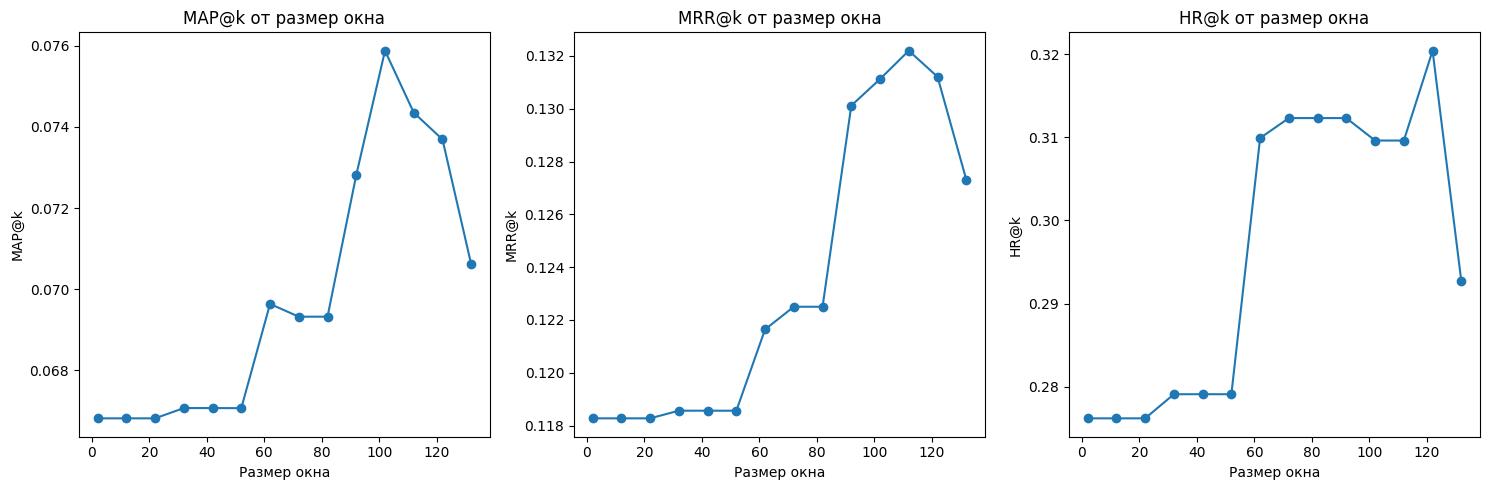

In [19]:
def evaluate_window_sizes(df, window_sizes, topn=10):
    results = {'map': [], 'mrr': [], 'hr': []}

    for window_size in window_sizes:
        toppop_weighted = TopPopularWeighted(min_window=window_size)
        toppop_weighted.fit(df)
        df['toppopular_weighted_recs'] = toppop_weighted.predict(df, topn=topn)
        metrics = evaluate_recommender(df, model_preds='toppopular_weighted_recs')

        results['map'].append(metrics['map'])
        results['mrr'].append(metrics['mrr'])
        results['hr'].append(metrics['hr'])

    return results

window_sizes = range(2, 140, 10)

metrics_results = evaluate_window_sizes(joined, window_sizes)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(window_sizes, metrics_results['map'], marker='o')
plt.title('MAP@k от размер окна')
plt.xlabel('Размер окна')
plt.ylabel('MAP@k')

plt.subplot(1, 3, 2)
plt.plot(window_sizes, metrics_results['mrr'], marker='o')
plt.title('MRR@k от размер окна')
plt.xlabel('Размер окна')
plt.ylabel('MRR@k')

plt.subplot(1, 3, 3)
plt.plot(window_sizes, metrics_results['hr'], marker='o')
plt.title('HR@k от размер окна')
plt.xlabel('Размер окна')
plt.ylabel('HR@k')

plt.tight_layout()
plt.show()

In [22]:
print(*window_sizes)
print(*metrics_results['map'])
print(*metrics_results['mrr'])
print(*metrics_results['hr'])

2 12 22 32 42 52 62 72 82 92 102 112 122 132
0.06681718518518517 0.06681718518518517 0.06681718518518517 0.06707036772486773 0.06707036772486773 0.0670679789777022 0.06963702262849585 0.06932295472726127 0.06932295472726127 0.072815954617032 0.07587922471025448 0.07435321060090702 0.07369216739103049 0.07061011022927689
0.11827670634920635 0.11827670634920635 0.11827670634920635 0.11856670634920634 0.11856670634920634 0.11856492063492065 0.12164492063492065 0.1225015873015873 0.1225015873015873 0.1301163095238095 0.1311229365079365 0.13219515873015872 0.13120821428571428 0.12731444444444445
0.2762 0.2762 0.2762 0.2791 0.2791 0.2791 0.3099 0.3123 0.3123 0.3123 0.3096 0.3096 0.3204 0.2927


Подумайте и ответьте, как размер окна влияет на качество рекомендаций. Какое значение наилучшее, есть ли у этого разумное объяснение?

**Ответ:**

•	Маленькие окна (до 42) захватывают слишком мало контекста, что делает рекомендации слабыми.

•	Оптимальные окна (102-122) позволяют учесть достаточно информации без перегрузки модели.

•	Очень большие окна (132+) могут включать слишком много “шума”, снижая точность.

Наилучший размер окна – примерно 102-122, так как в этом диапазоне наблюдается максимальный рост map, mrr, hr ≈ 0.076, 0.132, 0.32.

**Задание №3. Метрики и k.**

Постройте зависимость значений MAP@K, MRR@K, HR@K для метода рекомендации по популярности. Возьмите какие-нибудь k, например, от 1 до 100, переберите значения и покажите на линейном графике.

In [ ]:
joined['toppopular_recs'] = toppop.predict(joined, topn=100)

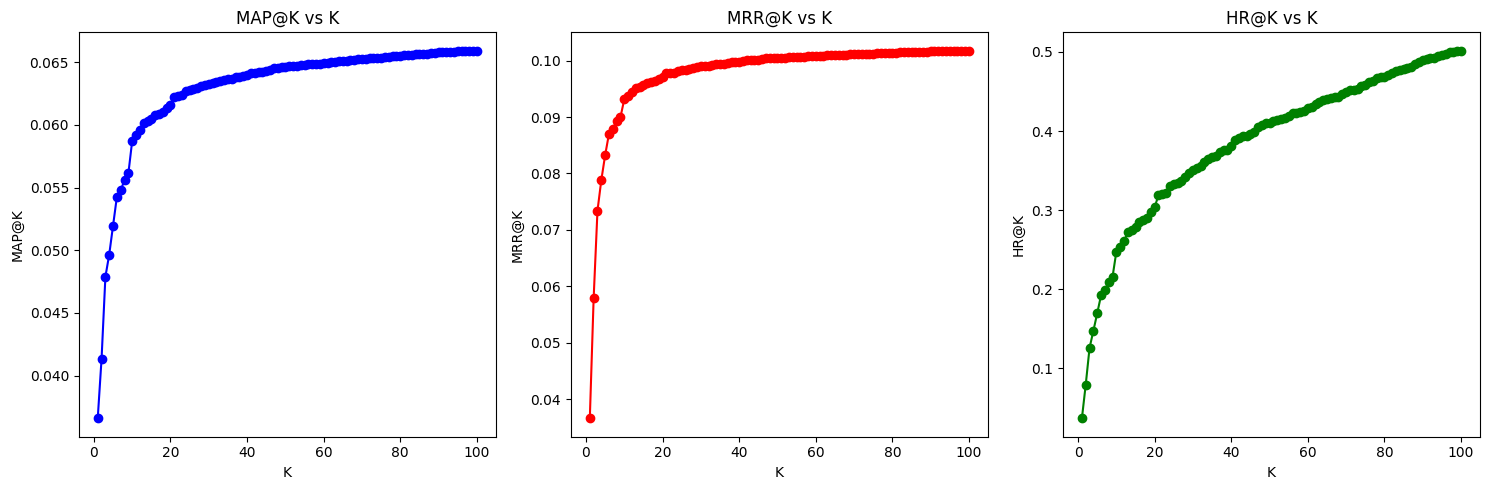

In [ ]:
def evaluate_metrics_at_k(df, model_preds, gt_col='test_interactions', max_k=100):
    map_values = []
    mrr_values = []
    hr_values = []

    for k in range(1, max_k + 1):
        metric_values = []

        for idx, row in df.iterrows():
            gt_items = [x[0] for x in row[gt_col]]
            predictions = row[model_preds][:k]

            ap = ap_metric(gt_items, predictions, topn=k)
            rr = rr_metric(gt_items, predictions, topn=k)
            hr = hr_metric(gt_items, predictions, topn=k)

            metric_values.append((ap, rr, hr))

        map_values.append(np.mean([x[0] for x in metric_values]))
        mrr_values.append(np.mean([x[1] for x in metric_values]))
        hr_values.append(np.mean([x[2] for x in metric_values]))

    return map_values, mrr_values, hr_values

map_values, mrr_values, hr_values = evaluate_metrics_at_k(joined, model_preds='toppopular_recs', max_k=100)

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, 101), map_values, marker='o', color='b')
plt.title('MAP@K vs K')
plt.xlabel('K')
plt.ylabel('MAP@K')

plt.subplot(1, 3, 2)
plt.plot(range(1, 101), mrr_values, marker='o', color='r')
plt.title('MRR@K vs K')
plt.xlabel('K')
plt.ylabel('MRR@K')

plt.subplot(1, 3, 3)
plt.plot(range(1, 101), hr_values, marker='o', color='g')
plt.title('HR@K vs K')
plt.xlabel('K')
plt.ylabel('HR@K')

plt.tight_layout()
plt.show()

Хорошенько подумайте и ответьте на вопросы ниже.

3.1 Какие из метрик являются монотонными функциями по top-K? Объясните, почему они являются монотонными? \
**Ответ:**

HR@K всегда монотонно возрастает с увеличением K.
Это связано с тем, что с увеличением K вероятность найти хотя бы один релевантный элемент в рекомендациях увеличивается. Даже если новые элементы не релевантны, значение HR@K не уменьшается, так как оно зависит только от наличия хотя бы одного релевантного элемента в топ-K.

MAP@K и MRR@K не являются монотонными функциями. Они могут как увеличиваться, так и уменьшаться с ростом K:
MAP@K учитывает порядок релевантных элементов. Если новые элементы в рекомендациях не релевантны, это может снизить среднюю точность.
MRR@K зависит от позиции первого релевантного элемента. Если первый релевантный элемент находится глубоко в списке, увеличение K может улучшить MRR@K, но если новые элементы не релевантны, это не повлияет на MRR@K.

3.2 Объясните по каждой метрике, как можно интерпретировать ее график? То есть, что можно сказать про связь изменения метрики c возможными пользовательскими сценариями, например,скроллингом ленты новостей. \
**Ответ:**

График MAP@K показывает, насколько точно рекомендации соответствуют предпочтениям пользователя с учётом порядка элементов. (Наш график в опредеденный момент (k примерно 30) практически остается неизменным)

*Если пользователь скроллит ленту новостей, рост MAP@K говорит о том, что он находит релевантный контент как в начале, так и в конце ленты. Снижение MAP@K может указывать на то, что в конце ленты контент менее интересен*.


График MRR@K показывает, насколько быстро пользователь находит первый релевантный элемент. (Наш график в опредеденный момент (k примерно 20) практически остается неизменным)

*Если пользователь быстро находит интересный контент в начале ленты, MRR@K будет высоким даже при маленьком K. Если он вынужден скроллить дальше, MRR@K будет расти.*


График HR@K показывает, насколько часто в топ-K рекомендаций содержится хотя бы один релевантный элемент.

*Если пользователь скроллит ленту, рост HR@K говорит о том, что он с большой вероятностью найдёт что-то интересное, даже если придётся прокрутить много контента.*

3.3 Как вы думаете, почему графики выглядят именно так? Должны ли они возрастать/убывать, от чего это может зависеть? (Тут вам может помочь дополнительный анализ данных)\
**Ответ:**

Мне кажется наши графики соответствуют тому, как должны вести себя метрики, учитвая, что наши рекомендации строятся на основе популярных товаров. Графикb снизу показывает, что 200 фильмов покрывают 50% от всех просматриваемых. А если расссматривать все фильмы, то видно что небольшая часть от всех items покрывет почти все взаимодействия. Это подтверждает, что рекомендации по самым популярным фильмам будут вести себя как на наших графиках.

<ipython-input-23-02ab61c16ed2>:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  g = df.item_id.value_counts(True)[:200].cumsum().reset_index().reset_index()


<Axes: xlabel='index'>

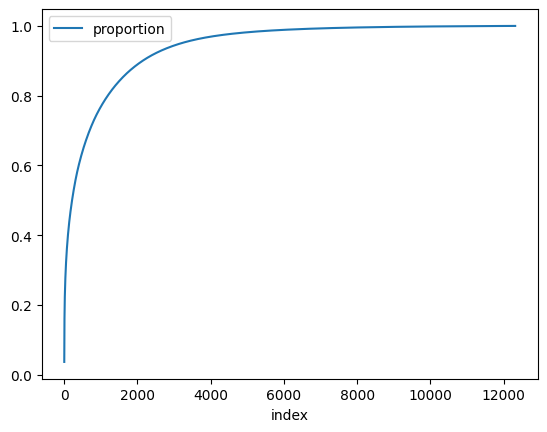

In [ ]:
g = df.item_id.value_counts(True)[:200].cumsum().reset_index().reset_index()
g.plot(x='index', y='proportion')

**Задание №4. Интерпретация рейтингов**

Возьмите названия фильмов/сериалов из `items.csv`, выделите 5 различных сценариев изменения популярности у фильмов, аргументируйте (например, графиком или статистикой) и проинтерпретируейте их (почему популярность для этого фильма меняется так). Обратите внимание, что надо найти именно разные паттерны изменения вероятностей.

In [26]:
items = pd.read_csv('items.csv')[['item_id','title']].copy()
items.head()

,item_id,title
0,10711,Поговори с ней
1,2508,Голые перцы
2,10716,Тактическая сила
3,7868,45 лет
4,16268,Все решает мгновение


Пример:

1917


<Axes: >

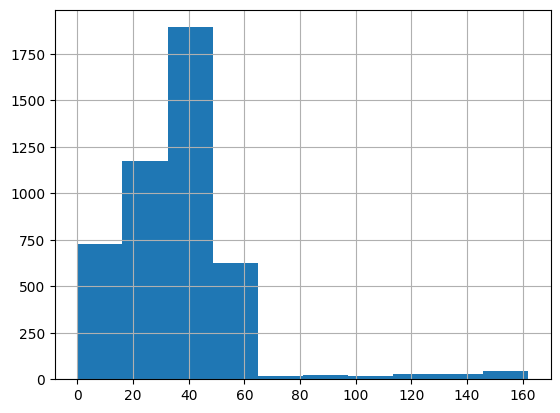

In [27]:
popular_items = df.item_id.value_counts()[:300].index.tolist()
sampled_id = np.random.choice(popular_items)

# это для примера, хотя выцеплять случаи по одному может быть не лучшей идеей
sampled_id = 3402

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Фильм 1917 какое-то время набирал популярность, потом видим резкое падение (кстати, с какой даты?). Возможно, это связано с ограничением доступности этого фильма для части пользователей, периодом проката фильма / рекламной кампании или другой причиной.

Добавьте 5 своих примеров ниже. Опишите, как вы их искали.

1) Найдем фильмы, который в первые 30 дней с момета первого просмотра набрал минимум 1000 просмотров.

In [24]:
def find_blockbusters(df, threshold=0.8, days=30, min_views=1000):
    first_watch = df.groupby("item_id")["last_watch_dt"].min()
    total_views = df["item_id"].value_counts()
    df["first_watch_dt"] = df["item_id"].map(first_watch)
    early_views = df[df["last_watch_dt"] <= (df["first_watch_dt"] + days)]["item_id"].value_counts()
    early_views = early_views[early_views >= min_views]
    ratio = (early_views / total_views).fillna(0)
    return ratio[ratio > threshold].index.tolist()

blockbusters = find_blockbusters(df, threshold=0.8, days=30, min_views=1000)
print(*blockbusters)

169 341 884 1136 1173 1381 1409 1465 1562 1626 2499 3269 3669 3784 3978 4218 4495 5124 5330 5505 6036 6209 6253 6311 6965 7014 7019 7033 7107 7144 7557 8181 8335 10074 10077 10152 10680 11047 11769 11863 11899 12133 12149 12360 12846 13099 13167 13325 13414 14378 14717 14817 15365 15384 15679 15942 16201


Лето - это море


<Axes: >

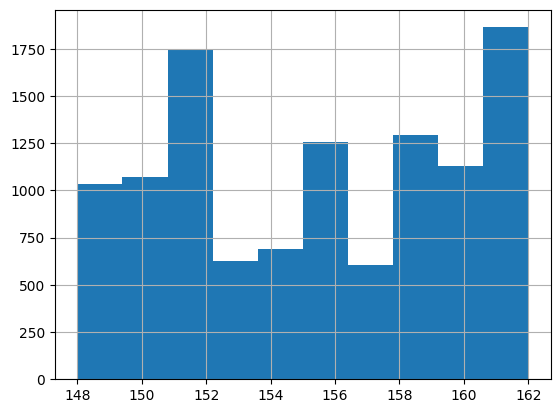

In [28]:
sampled_id = 341

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Этот фильм был популярен в период с 148 до 162 дня, можно предположить, что именно в 148 день фильм выложили и он сразу начал набирать просмотры, так как его могли рекомендовать специально и он нравился многим, так как название как раз соответствует периоду (самый разгар лета).

2) Найдем фильм который смотрели на протяжении всего периода (точнее 160 дней) и найдем пересечение с popular_items.

In [ ]:
def find_long_lasting(df):
    spread = df.groupby("item_id")["last_watch_dt"].agg(["min", "max"])
    duration = spread["max"] - spread["min"]
    return spread[duration > 160].index.tolist()

long_lasting = find_long_lasting(df)
long_lasting_pop = list(set(popular_items) & set(long_lasting))

print(*long_lasting_pop)

3.0 8202.0 8203.0 16397.0 8207.0 8212.0 24.0 28.0 35.0 8228.0 16420.0 8231.0 16426.0 47.0 8239.0 16433.0 16434.0 16438.0 16442.0 8252.0 16444.0 8254.0 8270.0 16464.0 85.0 86.0 8278.0 98.0 101.0 16488.0 111.0 112.0 8303.0 16498.0 16499.0 8316.0 16509.0 125.0 8319.0 140.0 141.0 144.0 8337.0 147.0 8340.0 149.0 8351.0 162.0 166.0 8359.0 170.0 172.0 8367.0 8386.0 203.0 211.0 212.0 218.0 237.0 8430.0 241.0 242.0 8442.0 8447.0 8461.0 274.0 8471.0 281.0 285.0 8489.0 298.0 304.0 308.0 8506.0 8513.0 329.0 8522.0 8524.0 334.0 8528.0 349.0 366.0 377.0 8570.0 8577.0 386.0 8579.0 389.0 8581.0 8582.0 8584.0 8585.0 411.0 8612.0 8617.0 8618.0 8632.0 8639.0 8643.0 459.0 460.0 461.0 470.0 8662.0 8680.0 8681.0 8685.0 496.0 8694.0 8698.0 509.0 517.0 521.0 522.0 8714.0 8725.0 548.0 8741.0 8752.0 561.0 565.0 579.0 8772.0 8776.0 8784.0 8789.0 599.0 602.0 608.0 615.0 8809.0 8810.0 623.0 8815.0 8821.0 8822.0 8830.0 652.0 8849.0 8850.0 8855.0 669.0 682.0 8878.0 8879.0 8880.0 697.0 8892.0 8896.0 710.0 8903.0 713.

<ipython-input-29-72b8262a2fe6>:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  popular_items = df.item_id.value_counts()[:300].index.tolist()


Простые сложности


<Axes: >

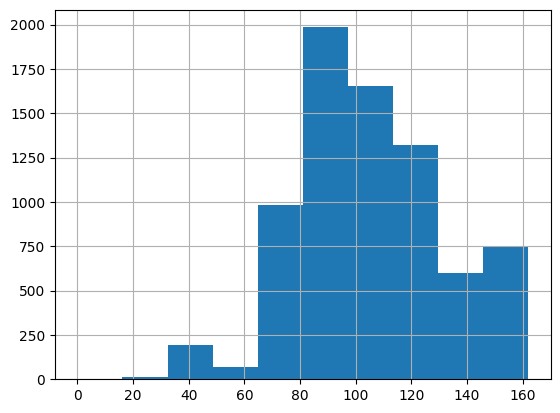

In [ ]:
sampled_id = 11778

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Как видно в начале фильм не был сильно популярным, но в итоге стал сильно набирать обороты и под конец графика опять немного упал. Примерный сценарий развития событий мог быть следующим:

Фильм, будучи старым, изначально не привлёк внимания, но позже смог стать популярным например благодаря рекомендациям платформы, положительным отзывам или упоминаниям в социальных сетях, а затем интерес угас, так как основная аудитория уже его посмотрела.

3) Найдем фильмы с минимальным количеством взаимодействий с ним = 100 на прояжении 20 периодов с длительностью 8 дней (захватывает почти весь период)

In [ ]:
def find_long_term_popular(df, min_views=50, min_periods=20, period_length=8):
    df["time_period"] = df["last_watch_dt"] // period_length

    popularity = df.groupby(["item_id", "time_period"]).size().unstack(fill_value=0)

    popular_count = (popularity > min_views).sum(axis=1)

    return popular_count[popular_count >= min_periods].index.tolist()

long_term_popular = find_long_term_popular(df)
print(*long_term_popular)


24.0 101.0 496.0 682.0 849.0 931.0 1287.0 1554.0 1785.0 1819.0 1844.0 1873.0 1978.0 2358.0 2722.0 2852.0 2956.0 3095.0 3509.0 3587.0 3940.0 4400.0 4436.0 4475.0 5471.0 5533.0 5693.0 5754.0 6455.0 6626.0 6649.0 6968.0 7210.0 7417.0 7626.0 8618.0 8821.0 9169.0 9214.0 9937.0 10073.0 10772.0 10942.0 11237.0 11345.0 12501.0 12659.0 12841.0 12849.0 13941.0 14120.0 14317.0 14431.0 14470.0 14703.0 15078.0 15266.0 15399.0 15464.0 15531.0 16291.0


Мстители: Эра Альтрона


<ipython-input-31-36c55f4e05bf>:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  popular_items = df.item_id.value_counts()[:300].index.tolist()


<Axes: >

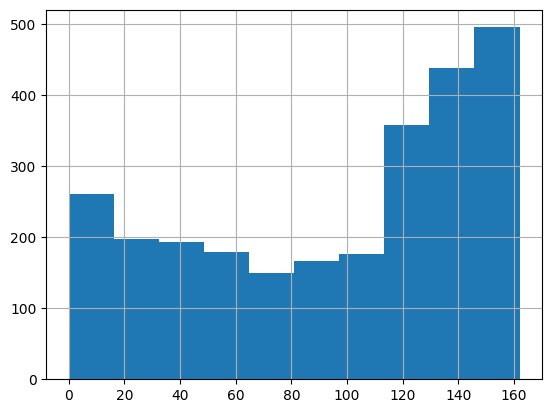

In [ ]:
sampled_id = 682

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Железный человек 3


<ipython-input-32-b0579fcaca42>:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  popular_items = df.item_id.value_counts()[:300].index.tolist()


<Axes: >

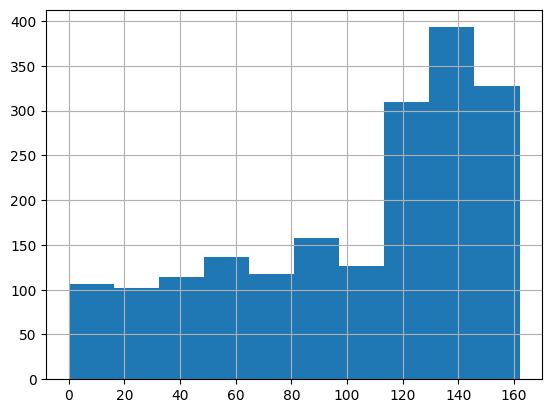

In [ ]:
sampled_id = 144

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Как можно заметить фильмы "Железный человек 3" и "Мстители: Эра Альтрона" относятся к киновселенной Marvel и оба пользуются популярностью на протяжении всего периода, но пик приходится на начало лето. Это возможно сязано с целевой аудторией (школьники) у которых с началом лета появляется больше свободного времени.

4) Найдем фильмы с большим количеством просморов и резким спадом:

In [ ]:
def find_long_term_with_drop(df, min_views=1000, min_periods=5, drop_factor=1000, period_length=20):
    df["time_period"] = df["last_watch_dt"] // period_length

    popularity = df.groupby(["item_id", "time_period"]).size().unstack(fill_value=0)

    long_term_popular = (popularity > min_views).sum(axis=1) >= min_periods

    drop_mask = (popularity.shift(-1, axis=1) * drop_factor <= popularity).any(axis=1)

    result = popularity.index[long_term_popular & drop_mask].tolist()
    return result

long_term_with_drop = find_long_term_with_drop(df)
print(*long_term_with_drop)


4740.0 7571.0 9728.0 13865.0 15297.0


Чкалов


<ipython-input-34-440fbdce1ff4>:1: FutureWarning: The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead
  popular_items = df.item_id.value_counts()[:300].index.tolist()


<Axes: >

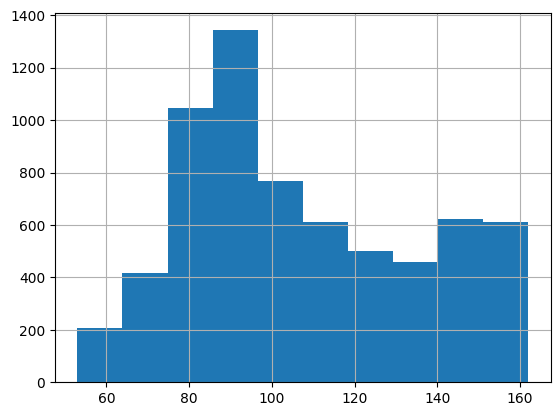

In [ ]:
sampled_id = 1449

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Чкалов - фильм о судьбе легендарного летчика на фоне становления советской авиации.

Сильные скачки просмотров приходятся на дни перед военными праздниками.

5) Найдем фильмы, у которых просмотры постепенно увеличиваются в течение 60+ дней.

In [41]:
def find_slow_growth(df, min_growth=2, period_length=30):
    df["month"] = df["last_watch_dt"] // period_length
    popularity = df.groupby(["item_id", "month"]).size().unstack(fill_value=0)

    growth_mask = (popularity.diff(axis=1) > 0).sum(axis=1) >= min_growth
    return popularity.index[growth_mask].tolist()

slow_growth_pop = list(set(popular_items) & set(find_slow_growth(df)))

print(*slow_growth_pop)


9728 512 11778 15362 3076 10240 10755 8199 3587 10761 14 1553 6162 1554 10772 10770 16406 14359 3095 5650 12324 15399 13865 12841 7210 15915 14378 11310 6192 11312 12849 14899 2100 14901 565 4151 11322 8252 5693 8254 16447 6208 15942 4685 8784 1617 11345 4689 11348 9811 10323 598 4696 9817 3669 13915 4702 14942 2657 8801 5732 101 15464 1131 1132 4716 3182 4718 13935 7793 12396 12908 9842 8821 6774 13941 5754 4731 16509 10878 9342 15997 14470 14476 4237 142 7310 11919 657 5266 4239 7829 14488 6809 2720 2722 4260 12965 676 4774 682 15531 5803 2220 9900 12463 12974 1204 3768 2237 10942 14526 12995 10436 9808 10440 11985 9937 12501 16087 16088 13018 3804 734 741 15078 13545 6382 1267 8437 7417 1785 12537 2301 9982 12544 6402 13058 9986 1287 1290 9996 14095 4880 13071 8986 1819 4382 288 9506 5411 2852 16166 8486 14120 2858 4400 1844 7476 2358 6455 6968 5434 12615 10569 3402 11769 334 12623 1873 4946 4436 341 10073 14684 2910 3935 5471 15199 4448 16228 13159 4457 10605 9070 14703 366 11118 1

Метро


<Axes: >

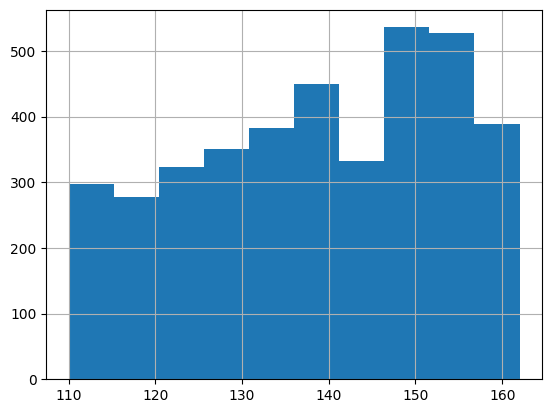

In [46]:
sampled_id = 8199

interactions = df.loc[df.item_id==sampled_id].copy()
name = items.loc[items.item_id==sampled_id].title.values[0]
print(name)
interactions.last_watch_dt.hist()

Действительно, рост просмотров с момента появления фильма на платформе постепенный. Это может быть связано с тем, что люди начинают делиться впечатлениями, писать отзывы, рекомендовать друзьям, хотя изначально фильм выходит без громкой рекламы и сильного продвижения. Если фильм постепенно получает высокие оценки, его начинают рекомендовать все большему количеству пользователей.

**Задание №5. User-item encoding**

Теперь, создайте матрицу интеракций user-item по примеру из семинара. Вам нужно в итоге получить разреженную матрицу (sparse matrix), в которой в качестве строк будут пользователи, в качестве колонок - айтемы. Не забудьте перекодировать пользователей и айтемы через энкодер. В отличие от семинара, оставьте в матрице только юзеров и айтемы, которые встречались в матрице > 4 раз.

Важно: когда вы отфильтруете юзеров на встречаемость > 4 раз, вы удалите какие-то айтемы, которые теперь станут встречаться меньше 5 раз. Поэтому у вас перестанет выполняться второе условие на минимальное число интеракций с айтемом. Тогда вам надо опять отфильтровать айтемы на встречаемость, но это снова может нарушить условие для юзеров. В таком случае, вам надо написать итеративный алгоритм до сходимости, пока требования не будут выполняться в обеих колонках.

In [ ]:
def filter_column(df, col, min_freq):
    """
    Filter dataframe, excluding least active users and least popular items.
    Return a copy of the dataframe with at least min_freq entries
    in both users and items
    """
    freq = df[col].value_counts()
    valid_ids = freq[freq >= min_freq].index
    return df[df[col].isin(valid_ids)]

def filter_dataframe(df, cols, min_freq=5):
    """
    Filter dataframe by given columns until each of them satisfies
    min_freq condition, guaranteed by filter_columns. Return a copy
    of the dataframe
    """
    while True:
        prev_shape = df.shape
        for col in cols:
            df = filter_column(df, col, min_freq)
        if df.shape == prev_shape:
            break
    return df

filtered_train = filter_dataframe(df, cols=['user_id', 'item_id'], min_freq=5)


In [ ]:
def df_encode(df):
    item2id = {k: v for v, k in enumerate(df.item_id.unique())}
    user2id = {k: v for v, k in enumerate(df.user_id.unique())}

    id2item = {v: k for k, v in item2id.items()}
    id2user = {v: k for k, v in user2id.items()}

    df['user_id'] = df.user_id.apply(lambda x: user2id[x])
    df['item_id'] = df.item_id.apply(lambda x: item2id[x])

    return df, item2id, user2id, id2item, id2user

filtered_train, item2id, user2id, id2item, id2user = df_encode(filtered_train)
filtered_train.sample(5)

,user_id,item_id,last_watch_dt,total_dur,watched_pct,first_watch_dt,time_period
2348204,184861,1092,138,8313.0,100.0,0,6
570383,158094,722,34,8121.0,100.0,20,1
904298,39021,3262,159,9443.0,100.0,122,7
2924949,180146,113,140,5.0,0.0,103,7
3283837,164546,1507,130,7544.0,100.0,34,6


In [ ]:
from scipy import sparse as sps

matrix = sps.coo_matrix(
    (np.ones(filtered_train.shape[0]), (filtered_train['user_id'], filtered_train['item_id'])),
    shape=(len(user2id), len(item2id)),
)
matrix

<203370x8737 sparse matrix of type '<class 'numpy.float64'>'
	with 2396591 stored elements in COOrdinate format>

**Задание №6. Интеракции и частота**

Постройте график зависимости количества айтемов и юзеров от значений (порогов) фильтров на встречаемость в матрице интеракций. То есть, нужно выполнить задание №5 для нескольких значений `min_freq` и построить график зависимости числа оставшихся айтемов и юзеров от этого параметра.

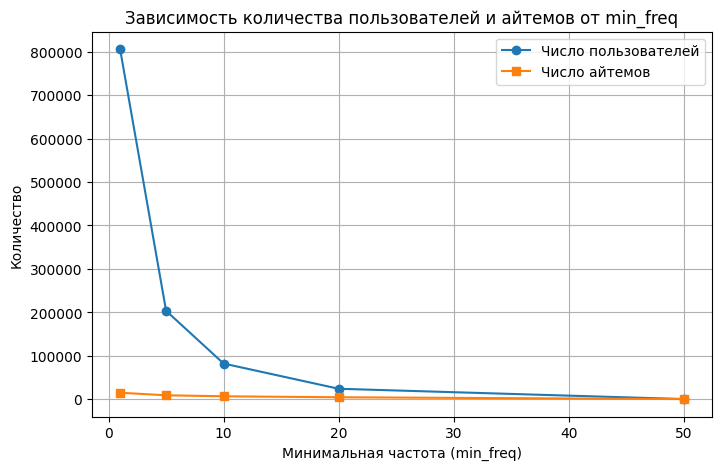

In [ ]:
min_freq_values = [1, 5, 10, 20, 50]
user_counts = []
item_counts = []

for min_freq in min_freq_values:
    filtered_df = filter_dataframe(df, cols=['user_id', 'item_id'], min_freq=min_freq)
    user_counts.append(filtered_df['user_id'].nunique())
    item_counts.append(filtered_df['item_id'].nunique())

plt.figure(figsize=(8, 5))
plt.plot(min_freq_values, user_counts, marker='o', linestyle='-', label='Число пользователей')
plt.plot(min_freq_values, item_counts, marker='s', linestyle='-', label='Число айтемов')

plt.xlabel('Минимальная частота (min_freq)')
plt.ylabel('Количество')
plt.title('Зависимость количества пользователей и айтемов от min_freq')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
print(min_freq_values)
print(user_counts)
print(item_counts)

[1, 5, 10, 20, 50]
[806295, 203370, 81858, 23785, 0]
[14652, 8737, 6419, 4177, 0]


**Задание №7. EASE**

Реализуйте EASE, постройте рекомендации для юзеров. Сравните все имплементированные ранее метрики качества с `TopPopular` для некоторого набора k.

Реализацию можно взять из семинара. Можно реализовать по статье https://arxiv.org/pdf/1905.03375.pdf. Можно взять и адаптировать из RecBole https://github.com/RUCAIBox/RecBole.

In [ ]:
%%time

def fit_ease(X, reg_weight=100):
    G = X.T @ X
    G += reg_weight * sps.identity(G.shape[0])
    G = G.todense()
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    np.fill_diagonal(B, 0.)

    return B

w = fit_ease(matrix)

CPU times: user 1min 49s, sys: 5.1 s, total: 1min 54s
Wall time: 1min 9s


Далее, вам надо реализовать функцию получения предсказаний. У вас есть обученная матрица весов, которую можно использовать для получения предсказаний. Для этого нужно построить вектор интеракций пользователя и умножить его на матрицу весов.

In [ ]:
def get_preds(x, item2id, id2item):
    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    vector = np.zeros(len(item2id))
    vector[encoded] = 1
    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]
    preds[encoded == 1] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:100]

    return decoded


joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, item2id, id2item))
joined.head()

,user_id,train_interactions,test_interactions,random_recs,toppopular_recs,toppopular_weighted_recs,ease_preds
0,304,"[(11985.0, 71), (175.0, 75), (4457.0, 99), (97...","[(6054.0, 161)]","[15659.0, 5392.0, 7185.0]","[10440.0, 15297.0, 9728.0, 13865.0, 3734.0, 41...","[9728.0, 10440.0, 15297.0, 13865.0, 3734.0, 37...","[13865.0, 10440.0, 10464.0, 3734.0, 14942.0, 7..."
1,777,"[(9728.0, 138)]","[(7307.0, 154)]","[15659.0, 5392.0, 7185.0]","[10440.0, 15297.0, 9728.0, 13865.0, 3734.0, 41...","[9728.0, 10440.0, 15297.0, 13865.0, 3734.0, 37...","[13865.0, 10440.0, 3734.0, 15297.0, 7829.0, 11..."
2,829,"[(13865.0, 150), (6965.0, 151), (5266.0, 152)]","[(4905.0, 153), (15531.0, 153), (512.0, 153), ...","[15659.0, 5392.0, 7185.0]","[10440.0, 15297.0, 9728.0, 13865.0, 3734.0, 41...","[9728.0, 10440.0, 15297.0, 13865.0, 3734.0, 37...","[15715.0, 9728.0, 10440.0, 512.0, 12995.0, 373..."
3,841,"[(3734.0, 146), (14359.0, 148)]","[(3935.0, 153)]","[15659.0, 5392.0, 7185.0]","[10440.0, 15297.0, 9728.0, 13865.0, 3734.0, 41...","[9728.0, 10440.0, 15297.0, 13865.0, 3734.0, 37...","[9728.0, 13865.0, 14431.0, 10440.0, 4151.0, 15..."
4,853,"[(565.0, 132), (10214.0, 133), (6143.0, 133), ...","[(9728.0, 153), (12356.0, 160)]","[15659.0, 5392.0, 7185.0]","[10440.0, 15297.0, 9728.0, 13865.0, 3734.0, 41...","[9728.0, 10440.0, 15297.0, 13865.0, 3734.0, 37...","[15297.0, 12743.0, 3541.0, 11899.0, 3734.0, 77..."


In [ ]:
evaluate_recommender(joined, model_preds='ease_preds')

{'map': 0.08019484615361093, 'mrr': 0.12356788476759689, 'hr': 0.6584}

{'map': 0.06842097945011337, 'mrr': 0.11892095238095239, 'hr': 0.2766}

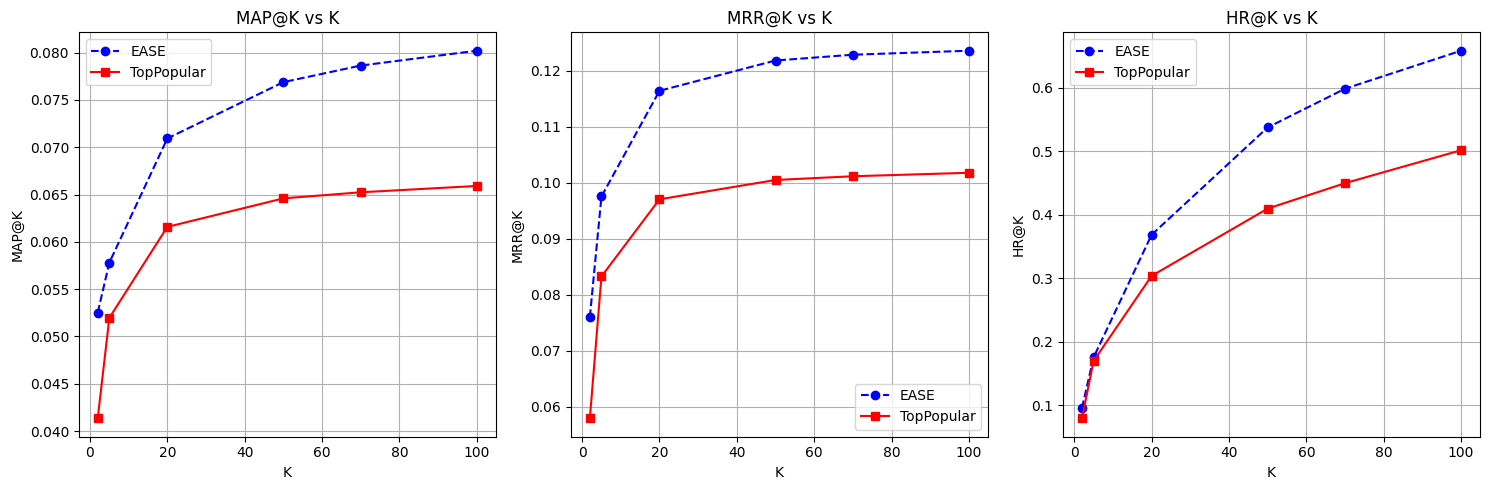

In [ ]:
def evaluate_metrics_at_k(df, model_preds, gt_col='test_interactions', max_k=100):
    map_values = []
    mrr_values = []
    hr_values = []

    for k in [2, 5, 20, 50, 70, 100]:
        metric_values = []

        for idx, row in df.iterrows():
            gt_items = [x[0] for x in row[gt_col]]
            predictions = row[model_preds][:k]

            ap = ap_metric(gt_items, predictions, topn=k)
            rr = rr_metric(gt_items, predictions, topn=k)
            hr = hr_metric(gt_items, predictions, topn=k)

            metric_values.append((ap, rr, hr))

        map_values.append(np.mean([x[0] for x in metric_values]))
        mrr_values.append(np.mean([x[1] for x in metric_values]))
        hr_values.append(np.mean([x[2] for x in metric_values]))

    return map_values, mrr_values, hr_values

pop_map_values, pop_mrr_values, pop_hr_values = evaluate_metrics_at_k(joined, model_preds='toppopular_recs', max_k=100)

ease_map_values, ease_mrr_values, ease_hr_values = evaluate_metrics_at_k(joined, model_preds='ease_preds', max_k=100)

plt.figure(figsize=(15, 5))

metrics = [
    ("MAP@K", ease_map_values, pop_map_values),
    ("MRR@K", ease_mrr_values, pop_mrr_values),
    ("HR@K", ease_hr_values, pop_hr_values)
]
colors = ['blue', 'red']

for i, (metric_name, ease_values, toppop_values) in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    plt.plot([2, 5, 20, 50, 70, 100], ease_values, marker='o', color=colors[0], linestyle='--', label="EASE")
    plt.plot([2, 5, 20, 50, 70, 100], toppop_values, marker='s', color=colors[1], linestyle='-', label="TopPopular")
    plt.title(f"{metric_name} vs K")
    plt.xlabel("K")
    plt.ylabel(metric_name)
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

Сделайте выводы — какой алгоритм работает лучше?

**Ответ:**  EASE показывала более хорошие результаты по всем метрикам, что подтверждает её эффективность в построении персонализированных рекомендаций. Это связано с тем, что:

EASE учитывает более сложные паттерны взаимодействий пользователей и айтемов, что приводит к более персонализированным и точным рекомендациям, в то время как TopPopular рекомендует только популярные айтемы, которые могут не подходить всем пользователям.

EASE может рекомендовать как популярные, так и нишевые айтемы, что делает её более гибкой по сравнению с TopPopular.

**Задание №8. Тюнинг**

Переберите различные значения гиперпараметра коэффициента регуляризации у EASE и постройте графики, как в задании №6. Постарайтесь "затюнить" EASE как можно лучше. Возьмите разумное число гиперпараметров - хотя бы штук 20 по логарифмической сетке, либо используйте более хитрые алгоритмы оптимизации.

Обучаем EASE с reg_weight = 0.01000
Обучаем EASE с reg_weight = 0.02069
Обучаем EASE с reg_weight = 0.04281
Обучаем EASE с reg_weight = 0.08859
Обучаем EASE с reg_weight = 0.18330
Обучаем EASE с reg_weight = 0.37927
Обучаем EASE с reg_weight = 0.78476
Обучаем EASE с reg_weight = 1.62378
Обучаем EASE с reg_weight = 3.35982
Обучаем EASE с reg_weight = 6.95193
Обучаем EASE с reg_weight = 14.38450
Обучаем EASE с reg_weight = 29.76351
Обучаем EASE с reg_weight = 61.58482
Обучаем EASE с reg_weight = 127.42750
Обучаем EASE с reg_weight = 263.66509
Обучаем EASE с reg_weight = 545.55948
Обучаем EASE с reg_weight = 1128.83789
Обучаем EASE с reg_weight = 2335.72147
Обучаем EASE с reg_weight = 4832.93024
Обучаем EASE с reg_weight = 10000.00000


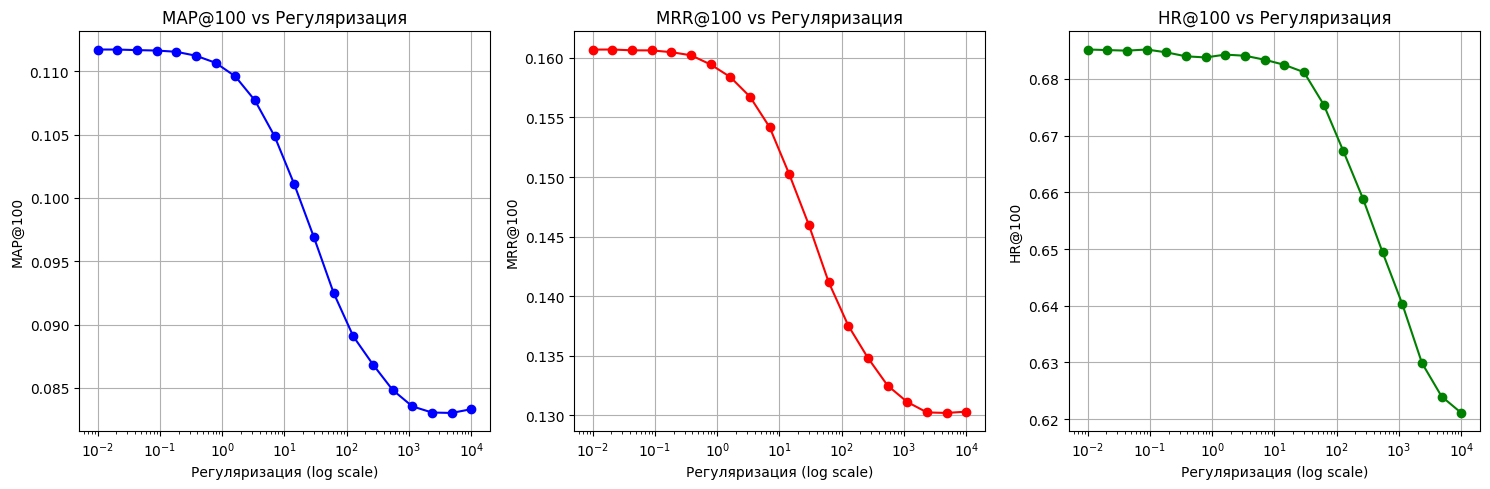

In [ ]:
def fit_ease(X, reg_weight):
    G = X.T @ X
    G += reg_weight * sps.identity(G.shape[0])
    G = G.todense()
    P = np.linalg.inv(G)
    B = P / (-np.diag(P))
    np.fill_diagonal(B, 0.)
    return B

def get_preds(x, w, item2id, id2item):
    user_items = [t[0] for t in x]
    encoded = [item2id[t] for t in user_items if t in item2id]

    vector = np.zeros(len(item2id))
    vector[encoded] = 1
    vector = sps.csr_matrix(vector)

    preds = np.array(vector.dot(w))[0]
    preds[encoded] = -np.inf

    ranks = np.argsort(-preds)
    decoded = [id2item[t] for t in ranks][:100]

    return decoded

reg_weights = np.logspace(-2, 4, 20)  # От 0.01 до 10 000

map_scores, mrr_scores, hr_scores = [], [], []

for reg in reg_weights:
    print(f"Обучаем EASE с reg_weight = {reg:.5f}")

    w = fit_ease(matrix, reg)

    joined['ease_preds'] = joined.train_interactions.apply(lambda x: get_preds(x, w, item2id, id2item))

    map_ease, mrr_ease, hr_ease = evaluate_metrics_at_k(joined, model_preds='ease_preds', max_k=100)

    map_scores.append(map_ease[-1])
    mrr_scores.append(mrr_ease[-1])
    hr_scores.append(hr_ease[-1])

plt.figure(figsize=(15, 5))

metrics = [
    ("MAP@100", map_scores),
    ("MRR@100", mrr_scores),
    ("HR@100", hr_scores)
]
colors = ['blue', 'red', 'green']

for i, (metric_name, values) in enumerate(metrics):
    plt.subplot(1, 3, i + 1)
    plt.plot(reg_weights, values, marker='o', color=colors[i], linestyle='-')
    plt.xscale('log')
    plt.title(f"{metric_name} vs Регуляризация")
    plt.xlabel("Регуляризация (log scale)")
    plt.ylabel(metric_name)
    plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
best_map_idx = np.argmax(map_scores)
best_mrr_idx = np.argmax(mrr_scores)
best_hr_idx = np.argmax(hr_scores)

best_reg_for_map = reg_weights[best_map_idx]
best_reg_for_mrr = reg_weights[best_mrr_idx]
best_reg_for_hr = reg_weights[best_hr_idx]

print(f"Лучший параметр регуляризации для MAP@100: {best_reg_for_map}")
print(f"Лучший параметр регуляризации для MRR@100: {best_reg_for_mrr}")
print(f"Лучший параметр регуляризации для HR@100: {best_reg_for_hr}")

Лучший параметр регуляризации для MAP@100: 0.01
Лучший параметр регуляризации для MRR@100: 0.0206913808111479
Лучший параметр регуляризации для HR@100: 0.01


Ответьте на следующие вопросы:

8.1 Какое значение гиперпараметра является наилучшим?


**Ответ:** 0.01

8.2 Что еще интересного вы можете сказать по графикам? Может быть, что-то свзяанное с распределением параметров, влиянием на отдельные метрики, скоростью тюнинга?

**Ответ:**
Оптимальное значение регуляризации:
Для MAP@100 и MRR@100 оптимальное значение регуляризации находится в районе 0.01, так как эти метрики достигают максимума при минимальном значении регуляризации.
Для HR@100 оптимальное значение регуляризации немного выше — около 0.08825.

Итог:

Слишком сильная регуляризация (начиная с 1.62 и выше) ухудшает все метрики, что говорит о том, что модель становится слишком простой и теряет способность к точным рекомендациям.
Слабая регуляризация (0.01–0.08825) позволяет модели лучше обучаться, но может привести к переобучению, если данные шумные или разреженные.

Также можно отметить, что HR@100 остается относительно стабильным при малых значениях регуляризации (от 0.01 до 1.62), но начинает снижаться при дальнейшем увеличении регуляризации. А MAP@100 и MRR@100 более чувствительны к регуляризации.

**Задание №9. EASE и topk**

В лекции №2 говорилось, что качество у EASE растет с ослаблением фильтра на число айтемов. В этом задании постройте кривые метрик качества MAP/MRR/HR в зависимости от topk (например, от 1 до 100 с некоторым шагом), где кривая параметризована минимальным требуемым значением встречаемости user/item (из задания №6). Опишите свои выводы.

<ipython-input-13-0144e5e0271a>:9: RuntimeWarning: invalid value encountered in scalar divide
  ap = np.sum(precision_at_k * relevant) / min(topn, n_u)


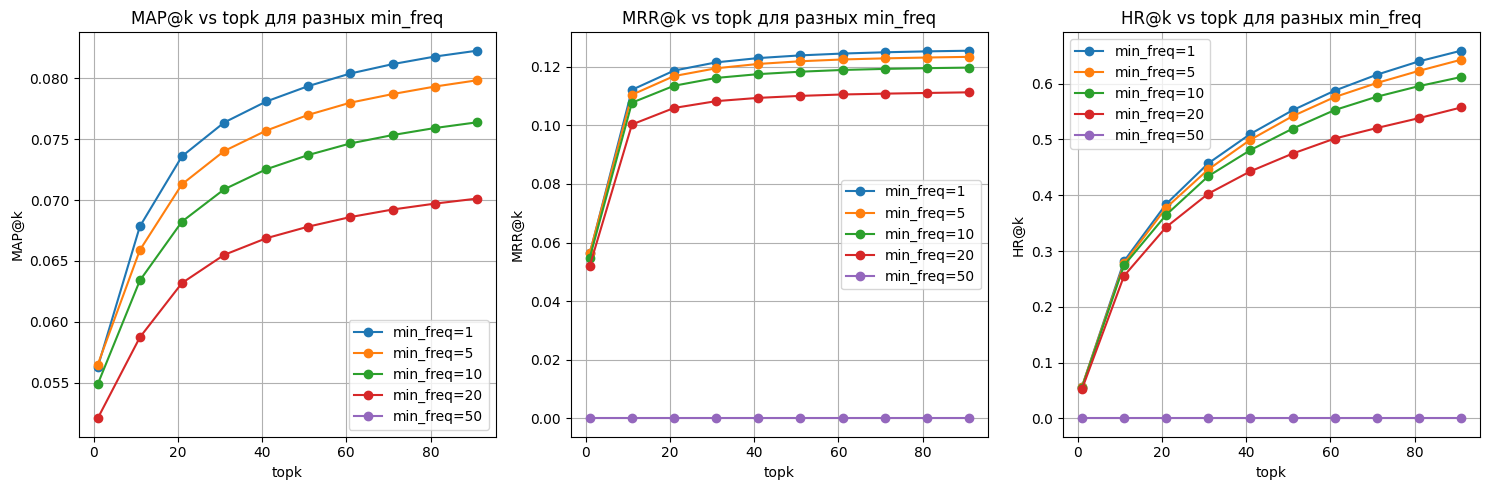

In [ ]:
min_freq_values = [1, 5, 10, 20, 50]

topk_values = list(range(1, 101, 10))

map_scores = {min_freq: [] for min_freq in min_freq_values}
mrr_scores = {min_freq: [] for min_freq in min_freq_values}
hr_scores = {min_freq: [] for min_freq in min_freq_values}

for min_freq in min_freq_values:
    filtered_df = filter_dataframe(df, cols=['user_id', 'item_id'], min_freq=min_freq)
    filtered_df, item2id, user2id, id2item, id2user = df_encode(filtered_df)

    matrix = sps.coo_matrix(
        (np.ones(filtered_df.shape[0]), (filtered_df['user_id'], filtered_df['item_id'])),
        shape=(len(user2id), len(item2id)),
    )

    w = fit_ease(matrix, reg_weight=100)

    for topk in topk_values:
        joined['ease_preds'] = joined.train_interactions.apply(
            lambda x: get_preds(x, item2id, id2item)[:topk]
        )

        metrics = evaluate_recommender(joined, model_preds='ease_preds')

        map_scores[min_freq].append(metrics['map'])
        mrr_scores[min_freq].append(metrics['mrr'])
        hr_scores[min_freq].append(metrics['hr'])

plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
for min_freq in min_freq_values:
    plt.plot(topk_values, map_scores[min_freq], marker='o', label=f'min_freq={min_freq}')
plt.xlabel('topk')
plt.ylabel('MAP@k')
plt.title('MAP@k vs topk для разных min_freq')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 2)
for min_freq in min_freq_values:
    plt.plot(topk_values, mrr_scores[min_freq], marker='o', label=f'min_freq={min_freq}')
plt.xlabel('topk')
plt.ylabel('MRR@k')
plt.title('MRR@k vs topk для разных min_freq')
plt.legend()
plt.grid(True)

plt.subplot(1, 3, 3)
for min_freq in min_freq_values:
    plt.plot(topk_values, hr_scores[min_freq], marker='o', label=f'min_freq={min_freq}')
plt.xlabel('topk')
plt.ylabel('HR@k')
plt.title('HR@k vs topk для разных min_freq')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Важно: в этом задании линии могут быть мало различимыми, поэтому ваша задача для каждой метрики найти нужный масштаб на каких-то конкретных topk, чтобы линии стали визуально отличимы.

Что вы можете сказать на основе полученных графиков? Соответствуют ли они вашим ожиданиям?

**Ответ:**

Ожидания были следующими:

Зависимость от k:

С увеличением topk значения MAP, MRR, HR будут расти так как учитывается больше элементов в рекомендациях, увеличивается вероятность найти релевантный элемент, увеличивается вероятность попадания релевантного элемента в топ соответственно.

Зависимость метрик от min_freq:

При меньших значениях min_freq значение MAP, MRR, HR будут выше, так как модель обучается на большем количестве данных.

Вывод: графики ведут себя как и ожидалось.

**Задание №10. Интерпретируемые рекомендации**

Используйте выученную матрицу весов для item2item рекомендаций. Приведите 10 примеров топ-5 рекомендаций от EASE к сэмплируемым айтемам. Используйте названия фильмов вместо id при выводе рекомендаций.

In [ ]:
def get_item2item_recommendations(w, id2item, items_df, top_n=5, sample_size=10):
    item_ids = np.random.choice(list(id2item.keys()), size=sample_size, replace=False)
    recommendations = {}

    for item_id in item_ids:
        similar_items = np.argsort(-np.array(w[item_id]).flatten())[:top_n]
        item_name = items_df.loc[items_df.item_id == id2item[item_id], 'title'].values[0]
        similar_names = [
            items_df.loc[items_df.item_id == id2item[i], 'title'].values[0] for i in similar_items
        ]
        recommendations[item_name] = similar_names

    return recommendations

item2item_recs = get_item2item_recommendations(w, id2item, items, top_n=5, sample_size=10)

for item, recs in item2item_recs.items():
    print(f"Фильм: {item}")
    print(f"Топ-5 похожих фильмов: {', '.join(recs)}\n")

Фильм: Дорога чести
Топ-5 похожих фильмов: Грешники и святые, Курьер, Бешеные, Ганмен, Точка невозврата

Фильм: Трудно быть богом
Топ-5 похожих фильмов: Муза смерти, Морские паразиты, Веном, Звёздные войны: Эпизод 4 — Новая надежда, Halo: Сумерки

Фильм: Русское Краткое. Выпуск 3
Топ-5 похожих фильмов: Афера, Тайны Бермудского треугольника, Мстители: Финал, День города, Маша

Фильм: Секс и ничего лишнего
Топ-5 похожих фильмов: Клиника счастья, Студентка по вызову, Молодость, Тайное влечение, Любовь

Фильм: Смешарики. Азбука здоровья
Топ-5 похожих фильмов: Смешарики: Пин-код, Сексоголики, Последний богатырь, Чебурашка, Смешарики. Азбука доброжелательности

Фильм: Поздняя любовь
Топ-5 похожих фильмов: Клиника счастья, Букет, Чего хотят мужчины, Ночная фиалка, Гнев человеческий

Фильм: Токийское восьмибалльное
Топ-5 похожих фильмов: Акудама Драйв, Эхо террора, Human Lost: Исповедь неполноценного человека, Школа под прицелом, Железный человек 2

Фильм: Инфекция
Топ-5 похожих фильмов: Инфек

In [ ]:
item2item_recs = get_item2item_recommendations(w, id2item, items, top_n=5, sample_size=10)

for item, recs in item2item_recs.items():
    print(f"Фильм: {item}")
    print(f"Топ-5 похожих фильмов: {', '.join(recs)}\n")

Фильм: 8 первых свиданий
Топ-5 похожих фильмов: Прабабушка легкого поведения, Привычка расставаться, Статус: Свободен, Анатомия страсти, Выкрутасы

Фильм: Эффективное жиросжигание
Топ-5 похожих фильмов: Маша, Рашн Юг, Ходячие мертвецы, Дуров, Императрица Ки

Фильм: Сталинград
Топ-5 похожих фильмов: Рядовой Чээрин, Девятаев, Девятаев - сериал, 9 рота, Железный рыцарь 2

Фильм: Дети в интернете (сурдоперевод + субтитры)
Топ-5 похожих фильмов: Простые правила, Молодожены, Простые правила (сурдоперевод + субтитры), Чкалов, Черное золото

Фильм: Дивергент, глава 3: за стеной
Топ-5 похожих фильмов: Дивергент, глава 2: инсургент, Дивергент, Бегущий в лабиринте, Голодные игры, Гнев человеческий

Фильм: Конец операции «Резидент»
Топ-5 похожих фильмов: Возвращение резидента, Судьба резидента, Легенда, Девятаев, Граф Монте-Кристо (1954)

Фильм: Падчерицы
Топ-5 похожих фильмов: Восемнадцатилетние развратницы, Семейные утехи 2, Нянечки, Завершение рабочего дня, Сексуальные игры

Фильм: Александр
То

Хорошие ли получились рекомендации? Почему? Есть ли хорошие примеры? Есть ли плохие? Почему бывают плохие примеры?

**Ответ:**

#### **Рекомендации получились хорошие, например:**

Фильм: Звёздные войны: Возвращение Джедая
Топ-5 похожих фильмов: Звёздные войны: Империя наносит ответный удар, Звёздные войны: Эпизод 4 — Новая надежда, Звёздные войны: Пробуждение силы, Звёздные войны: Атака клонов, Звёздные войны: Месть ситхов

В этом примере рекомендации получились логичные: предлагаются другие части фильма.

Фильм: Сталинград
Топ-5 похожих фильмов: Рядовой Чээрин, Девятаев, Девятаев - сериал, 9 рота, Железный рыцарь 2

Все фильмы относятся к военному жанру и боевикам, поэтому рекомендации уместны.

Фильм: Итальянец
Топ-5 похожих фильмов: Сделано в Италии, День города, Дебошир, Сумасшедшая любовь, Фестиваль Рифкина

Фильмы связаны тематически в этой подборке или похожи по жанру.

#### **Некоторые неудачные примеры тоже присутствуют, например:**

Фильм: Смешарики. Азбука здоровья
Топ-5 похожих фильмов: Смешарики: Пин-код, Сексоголики, Последний богатырь, Чебурашка, Смешарики. Азбука доброжелательности

Вообще рекомендации получились хорошими, но здесь явно есть проблема: модель считает, что между детским мультфильмом и фильмом "Cексоголики" есть связь, хотя возрастное ограничение этого фильма 18+.

Скорее всего это произошло потому что люди, смотревшие Смешариков, также любят фильмы другого характера, но модель не может видеть жанры и возрастные ограничения, поэтому могут возникать такие казусы.

Фильм: 30 дней ночи
Топ-5 похожих фильмов: Рядовой Чээрин, Девятаев, Пила 4, Приворот. Чёрное венчание, Штамм Андромеда

Почему-то первые 2 рекомендации для этого фильма военной тематики, хотя это неочевидно связано с фильмом ужасов "30 дней ночи", но последуюшие предложенные фильмы уже подходят по жанру.

#### **Итог:**

EASE основывается на матрице взаимодействий пользователей и может находить связи между фильмами, которые смотрели одни и те же люди, даже если они тематически не связаны, модель оперирует только на основе матрицы пользователь-айтем, игнорируя жанры, возрастные рейтинги и сюжетные особенности фильмов.

Я считаю, что модель получилась хорошей, действительно много релевантных рекомендаций, особенно когда речь идет о франшизах и тематически схожих фильмах.